# Setup

In [ ]:
# collab setup
!git clone https://github.com/kallioaa/frustration_msc.git
%cd /content/frustration_msc
import sys
from pathlib import Path

sys.path.insert(0, "/content/frustration_msc/src")

from google.colab import drive
drive.mount("/content/drive")

# google drive path 
RESULTS_PATH = Path("/content/drive/MyDrive/sweeps")


In [1]:
# local setup
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().resolve().parent.parent))

# local path
# google drive path 
RESULTS_PATH = Path("outputs/sweeps/")

In [2]:
from pathlib import Path
import pickle
import importlib

from experiments.sweep_plots import plot_sweep_training, plot_sweep_evaluation
from experiments.sweep_plots_helper import (
    taxi_training_plot_specs,
    taxi_evaluation_plot_specs,
    cliffwalking_training_plot_specs,
    cliffwalking_evaluation_plot_specs,
    frozenlake_training_plot_specs,
    frozenlake_evaluation_plot_specs,
)

In [3]:
# filtering for runs

from collections.abc import Iterable
from typing import Any


def _agent_kwargs(run: dict[str, Any]) -> dict[str, Any]:
    return run.get("params", {}).get("agent_kwargs", {}) or {}


# Confirmation-bias sweeps
def select_confirmatory_results(
    results: Iterable[dict[str, Any]],
) -> list[dict[str, Any]]:
    return [
        r
        for r in results
        if _agent_kwargs(r).get("alpha_conf", float("-inf"))
        > _agent_kwargs(r).get("alpha_disconf", float("inf"))
    ]


def select_unconfirmatory_results(
    results: Iterable[dict[str, Any]],
) -> list[dict[str, Any]]:
    return [
        r
        for r in results
        if _agent_kwargs(r).get("alpha_conf", float("inf"))
        < _agent_kwargs(r).get("alpha_disconf", float("-inf"))
    ]


def select_confirmation_baseline_results(
    results: Iterable[dict[str, Any]],
) -> list[dict[str, Any]]:
    # baseline: alpha_conf == alpha_disconf
    return [
        r
        for r in results
        if _agent_kwargs(r).get("alpha_conf") == _agent_kwargs(r).get("alpha_disconf")
    ]


# Positivity-bias sweeps
def select_positivity_biased_results(
    results: Iterable[dict[str, Any]],
) -> list[dict[str, Any]]:
    return [
        r
        for r in results
        if _agent_kwargs(r).get("alpha_positive", float("-inf"))
        > _agent_kwargs(r).get("alpha_negative", float("inf"))
    ]


def select_negativity_biased_results(
    results: Iterable[dict[str, Any]],
) -> list[dict[str, Any]]:
    return [
        r
        for r in results
        if _agent_kwargs(r).get("alpha_positive", float("inf"))
        < _agent_kwargs(r).get("alpha_negative", float("-inf"))
    ]


def select_positivity_baseline_results(
    results: Iterable[dict[str, Any]],
) -> list[dict[str, Any]]:
    # baseline: alpha_positive == alpha_negative
    return [
        r
        for r in results
        if _agent_kwargs(r).get("alpha_positive")
        == _agent_kwargs(r).get("alpha_negative")
    ]

In [4]:
from __future__ import annotations

import math
from typing import Any, Iterable


def _agent_kwargs_from_result(result: dict[str, Any]) -> dict[str, Any]:
    params = result.get("params", {}) or {}
    agent_kwargs = params.get("agent_kwargs", {}) or {}
    # Support both direct dict and {"config": {...}} style.
    if (
        isinstance(agent_kwargs, dict)
        and "config" in agent_kwargs
        and isinstance(agent_kwargs["config"], dict)
    ):
        return agent_kwargs["config"]
    return agent_kwargs


def _pair_matches(
    value_pair: tuple[float, float],
    allowed_pairs: Iterable[tuple[float, float]],
    tol: float,
) -> bool:
    a, b = value_pair
    return any(
        math.isclose(a, x, abs_tol=tol, rel_tol=0.0)
        and math.isclose(b, y, abs_tol=tol, rel_tol=0.0)
        for x, y in allowed_pairs
    )


def _result_seed(result: dict[str, Any]) -> int | None:
    params = result.get("params", {}) or {}
    agent_kwargs = params.get("agent_kwargs", {}) or {}
    env_kwargs = params.get("env_kwargs", {}) or {}

    seed = agent_kwargs.get("seed")
    if seed is None:
        seed = env_kwargs.get("seed")
    if seed is None:
        seed = params.get("seed")

    return int(seed) if seed is not None else None


def select_results(
    results: list[dict[str, Any]],
    ac_ad_pairs: Iterable[tuple[float, float]] | None = None,
    ap_an_pairs: Iterable[tuple[float, float]] | None = None,
    positivity_ratios: Iterable[float] | None = None,
    seeds: Iterable[int] | None = None,  # NEW: list of seeds
    tol: float = 1e-9,
) -> list[dict[str, Any]]:
    ac_ad_pairs = list(ac_ad_pairs or [])
    ap_an_pairs = list(ap_an_pairs or [])
    positivity_ratios = list(positivity_ratios or [])
    seed_set = {int(s) for s in (seeds or [])}

    # No filters at all
    if not ac_ad_pairs and not ap_an_pairs and not positivity_ratios and not seed_set:
        return list(results)

    out: list[dict[str, Any]] = []
    for r in results:
        # Seed filter (ANDed)
        if seed_set:
            rs = _result_seed(r)
            if rs is None or rs not in seed_set:
                continue

        # If only seed filter is used
        if not ac_ad_pairs and not ap_an_pairs and not positivity_ratios:
            out.append(r)
            continue

        ak = _agent_kwargs_from_result(r)
        matched = False

        if ac_ad_pairs:
            ac = ak.get("alpha_conf")
            ad = ak.get("alpha_disconf")
            if (
                ac is not None
                and ad is not None
                and _pair_matches((float(ac), float(ad)), ac_ad_pairs, tol)
            ):
                matched = True

        if not matched and ap_an_pairs:
            ap = ak.get("alpha_positive")
            an = ak.get("alpha_negative")
            if (
                ap is not None
                and an is not None
                and _pair_matches((float(ap), float(an)), ap_an_pairs, tol)
            ):
                matched = True

        if not matched and positivity_ratios:
            ap = ak.get("alpha_positive")
            an = ak.get("alpha_negative")
            if ap is not None and an is not None:
                ap = float(ap)
                an = float(an)
                if not math.isclose(an, 0.0, abs_tol=tol, rel_tol=0.0):
                    ratio = ap / an
                    if any(
                        math.isclose(ratio, target, abs_tol=tol, rel_tol=0.0)
                        for target in positivity_ratios
                    ):
                        matched = True

        if matched:
            out.append(r)

    return out

# Results

## Taxi V3

In [ ]:
# Taxi - confirmation bias
file_taxi_conf = RESULTS_PATH / "taxi_final_results" / "taxi_conf_all_pairs.pkl"
with file_taxi_conf.open("rb") as f:
    conf_results = pickle.load(f)
print(f"Loaded {len(conf_results)} runs from {file_taxi_conf}")

In [ ]:
plot_sweep_training(
    file_taxi_conf,
    window_size=500,
    start_episode=0,
    plot_specs=taxi_training_plot_specs(),
)

In [ ]:
plot_sweep_evaluation(results, window_size=300, plot_specs=taxi_evaluation_plot_specs())

In [ ]:
# download data for plots
# Taxi - positivity bias
file_taxi_pos = RESULTS_PATH / "taxi_final_results" / "taxi_pos_all_ratios.pkl"
with file_taxi_pos.open("rb") as f:
    pos_results = pickle.load(f)
print(f"Loaded {len(pos_results)} runs from {file_taxi_pos}")

## Cliff Walking

In [5]:
# CliffWalking  x confirmation bias
file_cliffwalking_conf = RESULTS_PATH / "cliffwalking_final_results" / "cliffwalking_conf_all_pairs.pkl"

with file_cliffwalking_conf.open("rb") as f:
    conf_results = pickle.load(f)
print(f"Loaded {len(conf_results)} runs from {file_cliffwalking_conf}")

# CliffWalking  x confirmation bias
file_cliffwalking_pos = (
    RESULTS_PATH / "cliffwalking_final_results" / "cliffwalking_pos_all_ratios.pkl"
)

with file_cliffwalking_pos.open("rb") as f:
    pos_results = pickle.load(f)
print(f"Loaded {len(pos_results)} runs from {file_cliffwalking_pos}")

cliffwalking_results = conf_results + pos_results

Loaded 165 runs from outputs/sweeps/cliffwalking_final_results/cliffwalking_conf_all_pairs.pkl
Loaded 90 runs from outputs/sweeps/cliffwalking_final_results/cliffwalking_pos_all_ratios.pkl


## Confirmation bias

In [34]:
conf_conf_results = select_confirmatory_results(conf_results) + select_confirmation_baseline_results(conf_results)
conf_disconf_results = select_unconfirmatory_results(conf_results) + select_confirmation_baseline_results(conf_results)

In [44]:
# Unique (alpha_conf, alpha_disconf) pairs from results
# Replace `results` with your variable, e.g. conf_results / conf_conf_results

pairs = sorted(
    {
        (
            (r.get("params", {}).get("agent_kwargs", {}) or {}).get("alpha_conf"),
            (r.get("params", {}).get("agent_kwargs", {}) or {}).get("alpha_disconf"),
        )
        for r in conf_results
        if (r.get("params", {}).get("agent_kwargs", {}) or {}).get("alpha_conf")
        is not None
        and (r.get("params", {}).get("agent_kwargs", {}) or {}).get("alpha_disconf")
        is not None
    }
)

print(f"Found {len(pairs)} unique ac/ad pairs:")
for p in pairs:
    print(p)

Found 11 unique ac/ad pairs:
(0.075, 0.325)
(0.1, 0.3)
(0.125, 0.275)
(0.15, 0.25)
(0.175, 0.225)
(0.2, 0.2)
(0.225, 0.175)
(0.25, 0.15)
(0.275, 0.125)
(0.3, 0.1)
(0.325, 0.075)


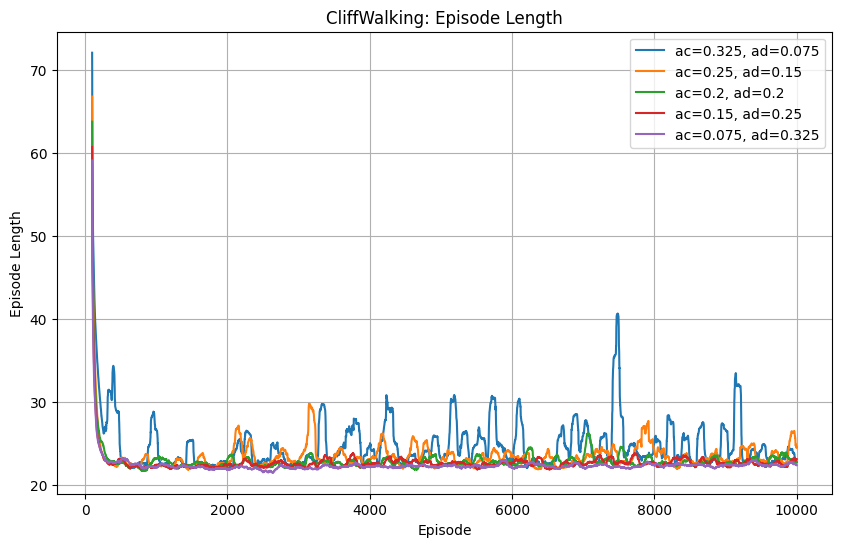

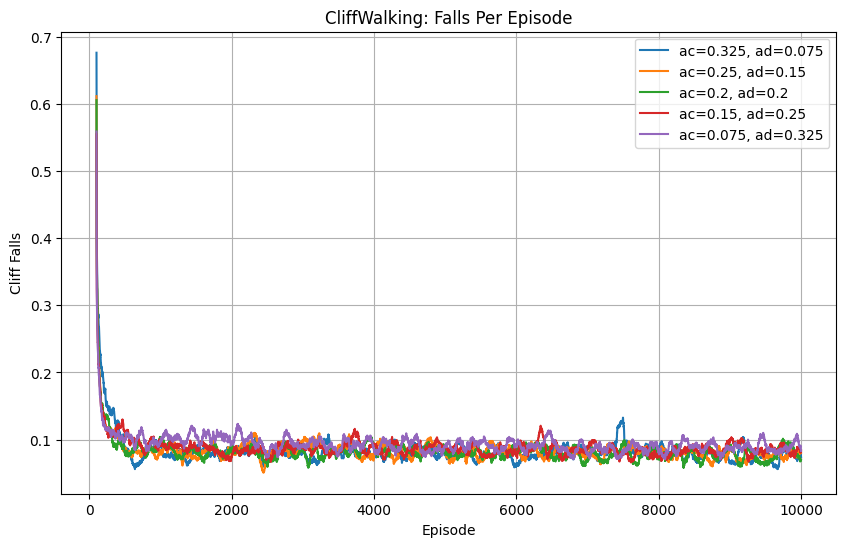

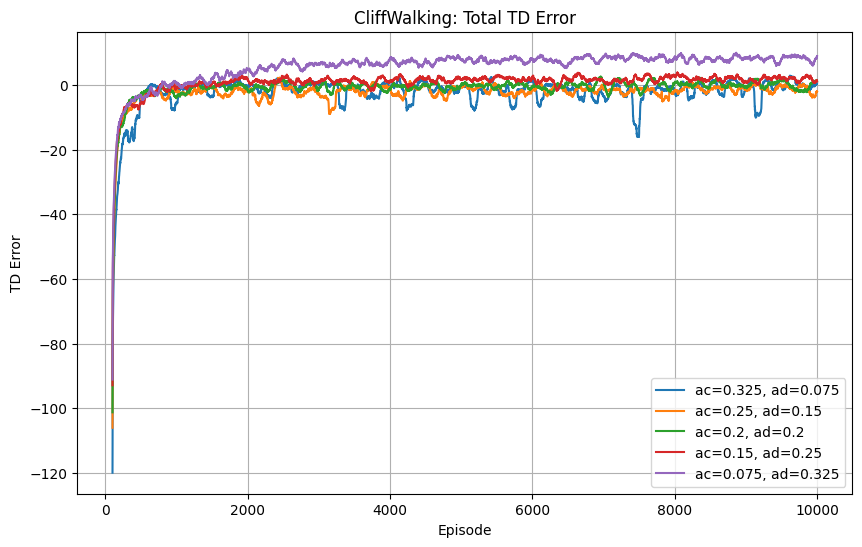

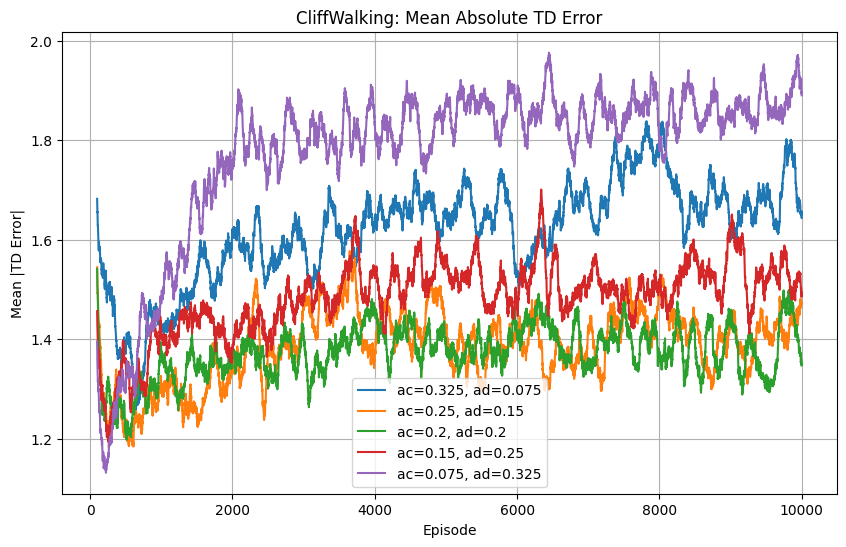

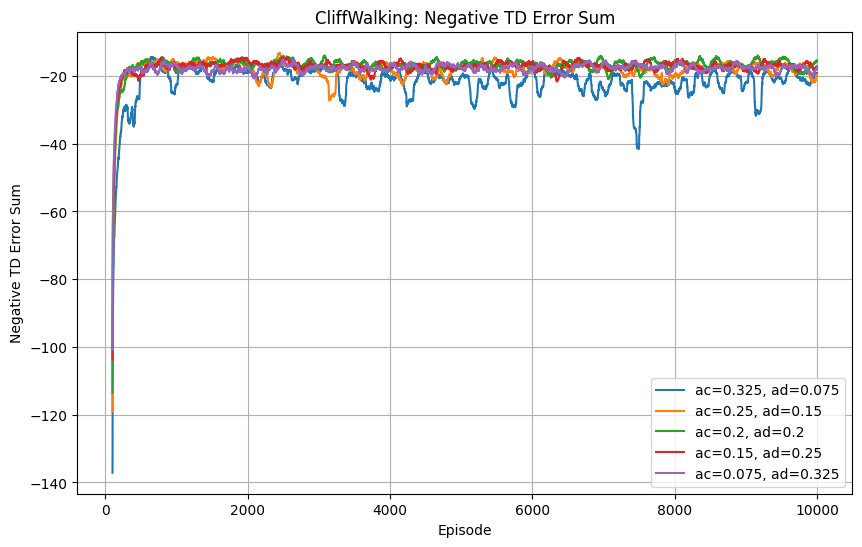

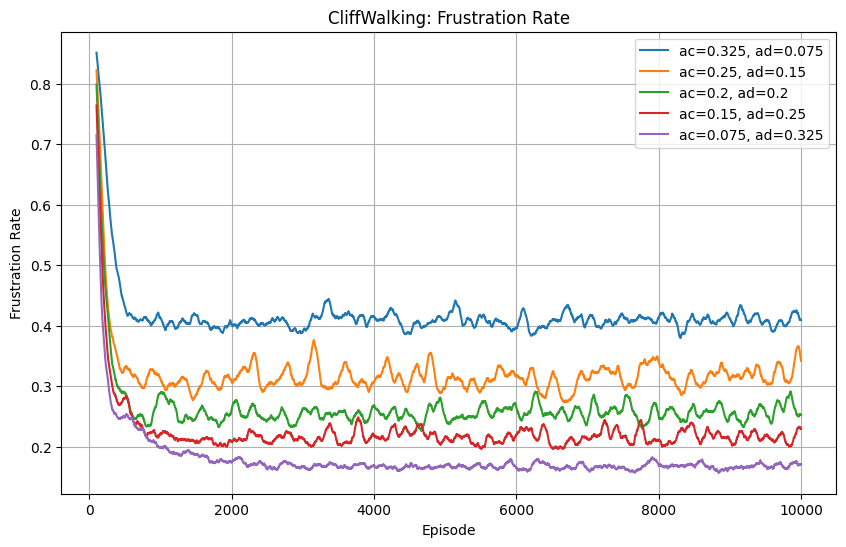

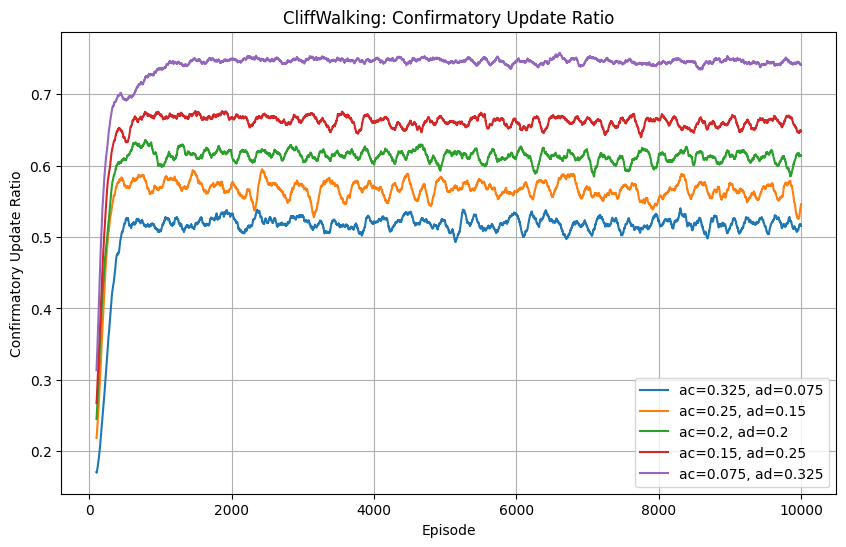

In [6]:
# all 15 sweeps

import importlib

from experiments.sweep_plots import plot_sweep_training
import experiments.sweep_plots_helper_thesis as thesis_cfg_mod

importlib.reload(thesis_cfg_mod)

cfg = thesis_cfg_mod.cliffwalking_training_thesis_config()

subset = select_results(
    conf_results,
    ac_ad_pairs=[(0.325, 0.075), (0.25, 0.15), (0.2, 0.2), (0.15, 0.25), (0.075, 0.325)],
)


plot_sweep_training(
    subset,
    window_size=cfg["window_size"],
    label_fn=cfg["label_fn"],
    plot_specs=cfg["plot_specs"],
    start_episode=cfg["start_episode"],
    end_episode=cfg["end_episode"],
    use_td_error_v=cfg["use_td_error_v"],
)

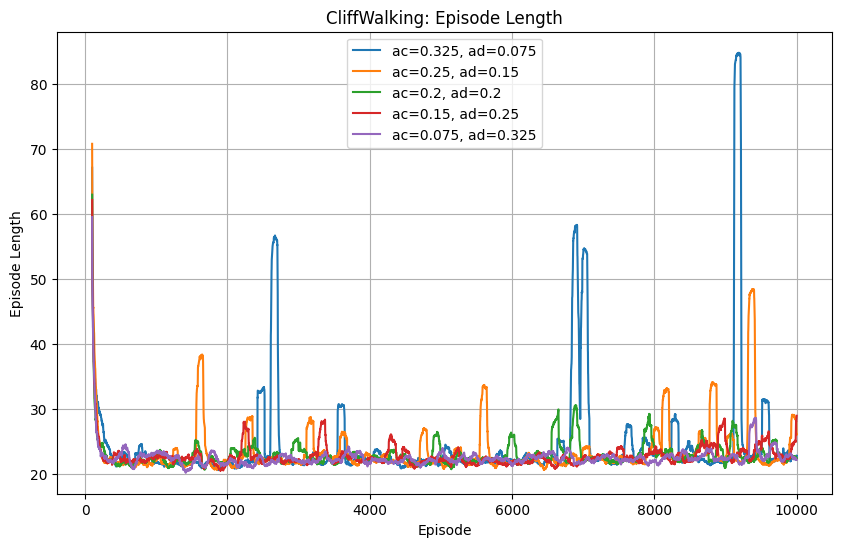

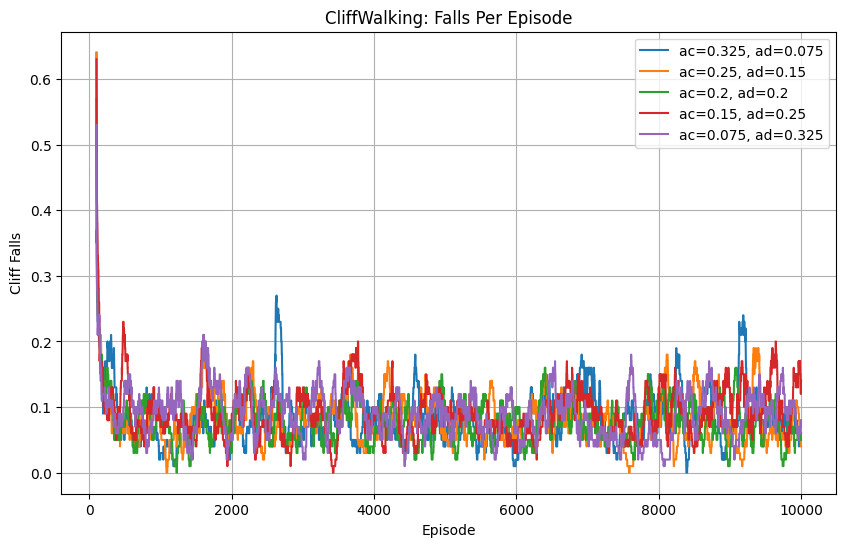

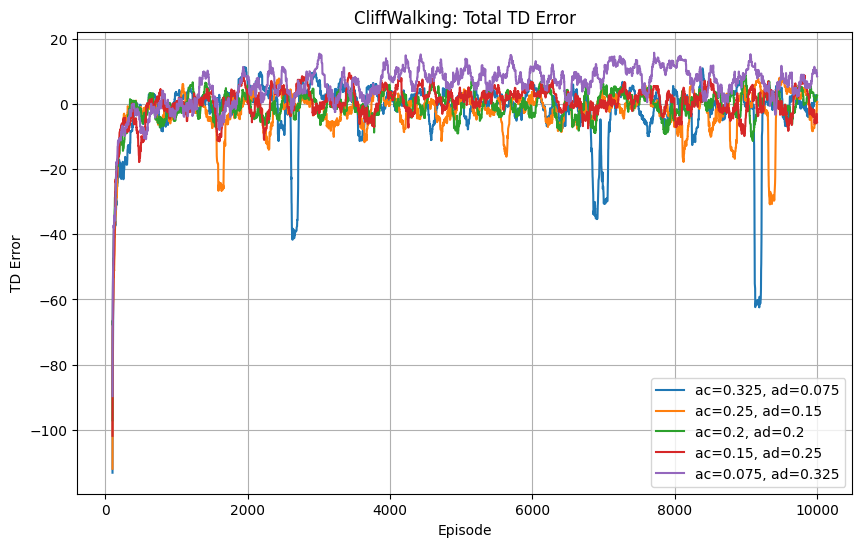

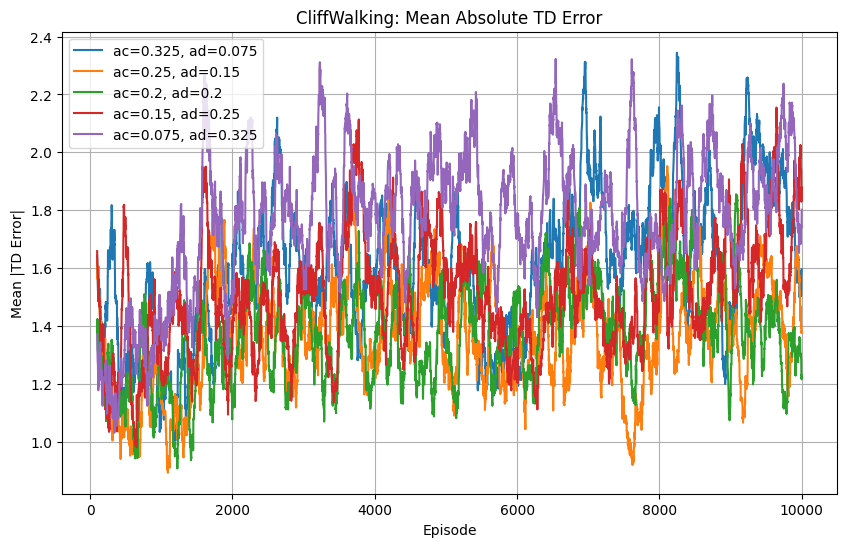

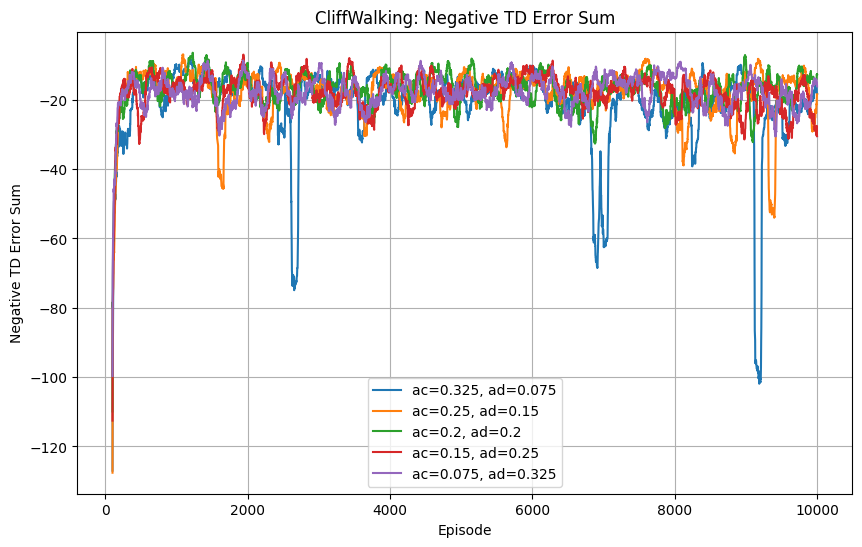

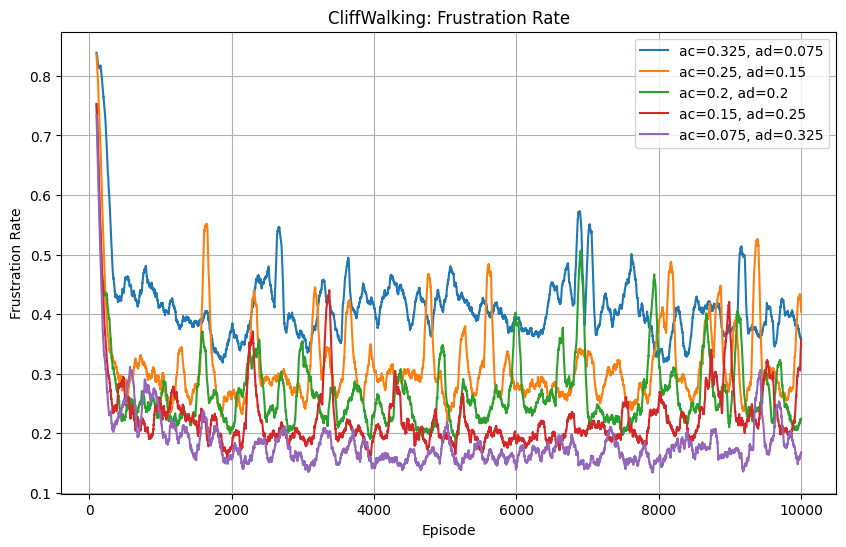

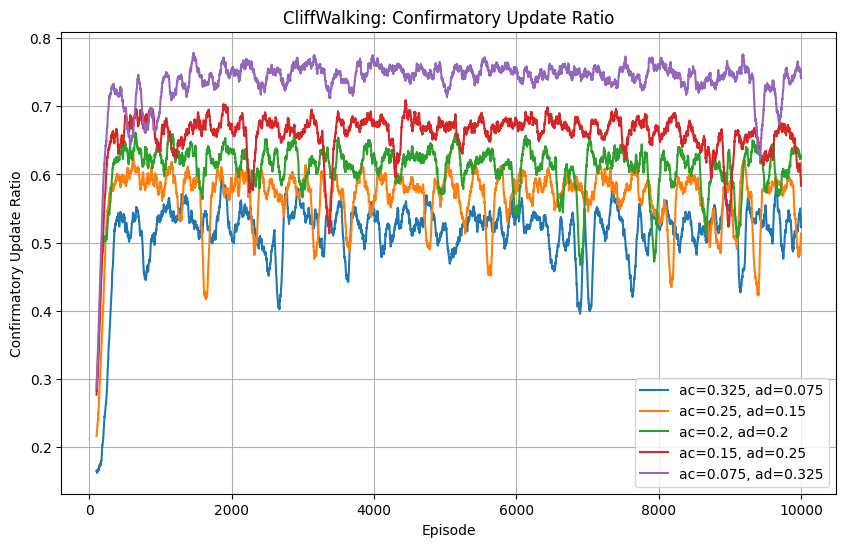

In [12]:
# one sweep
# all 15 sweeps

import importlib

from experiments.sweep_plots import plot_sweep_training
import experiments.sweep_plots_helper_thesis as thesis_cfg_mod

importlib.reload(thesis_cfg_mod)

cfg = thesis_cfg_mod.cliffwalking_training_thesis_config()

subset = select_results(
    conf_results,
    ac_ad_pairs=[
        (0.325, 0.075),
        (0.25, 0.15),
        (0.2, 0.2),
        (0.15, 0.25),
        (0.075, 0.325),
    ],
    seeds=[0]
)

plot_sweep_training(
    subset,
    window_size=cfg["window_size"],
    label_fn=cfg["label_fn"],
    plot_specs=cfg["plot_specs"],
    start_episode=cfg["start_episode"],
    end_episode=cfg["end_episode"],
    use_td_error_v=cfg["use_td_error_v"],
)

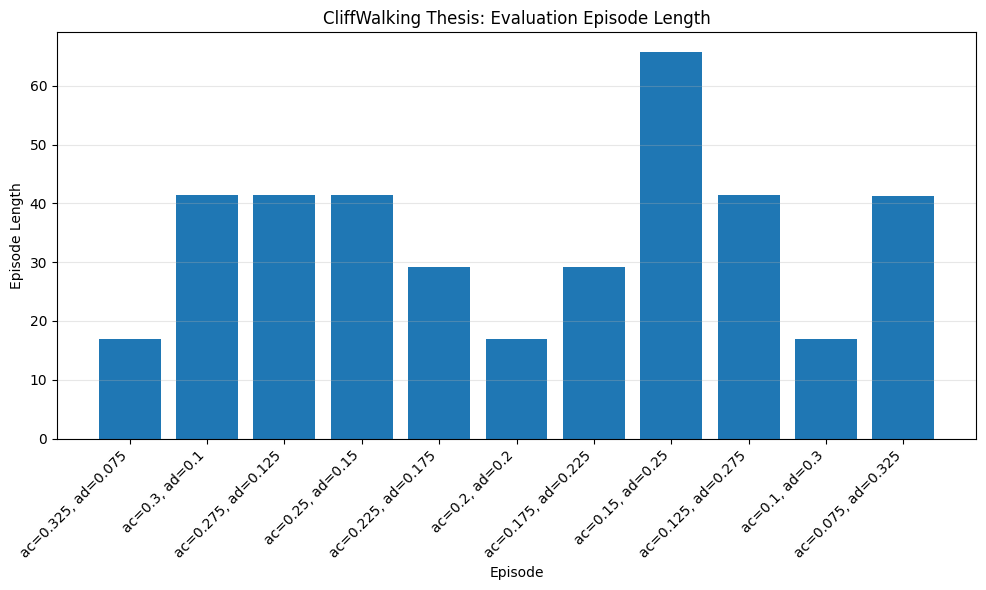

In [7]:
import importlib
import experiments.sweep_plots_helper_thesis as thesis_cfg_mod

importlib.reload(thesis_cfg_mod)

cfg = thesis_cfg_mod.cliffwalking_evaluation_thesis_config()

plot_sweep_evaluation(
    conf_results,
    window_size=cfg["window_size"],
    label_fn=cfg["label_fn"],
    plot_specs=cfg["plot_specs"],
    start_episode=cfg["start_episode"],
    end_episode=cfg["end_episode"],
)

## Positivity bias

In [ ]:
# all 15 sweeps
import experiments.sweep_plots_helper_thesis as thesis_cfg_mod
importlib.reload(thesis_cfg_mod)

cfg = thesis_cfg_mod.cliffwalking_training_thesis_config()

subset = select_results(
    pos_results,
    ac_ad_pairs=[
        (0.325, 0.075),
        (0.25, 0.15),
        (0.2, 0.2),
        (0.15, 0.25),
        (0.075, 0.325),
    ],
)


plot_sweep_training(
    subset,
    window_size=cfg["window_size"],
    label_fn=cfg["label_fn"],
    plot_specs=cfg["plot_specs"],
    start_episode=cfg["start_episode"],
    end_episode=cfg["end_episode"],
    use_td_error_v=cfg["use_td_error_v"],
)

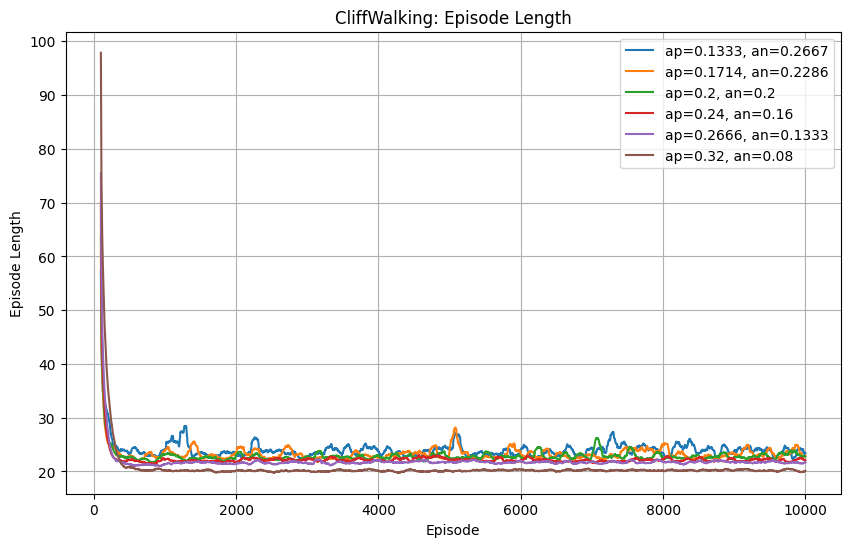

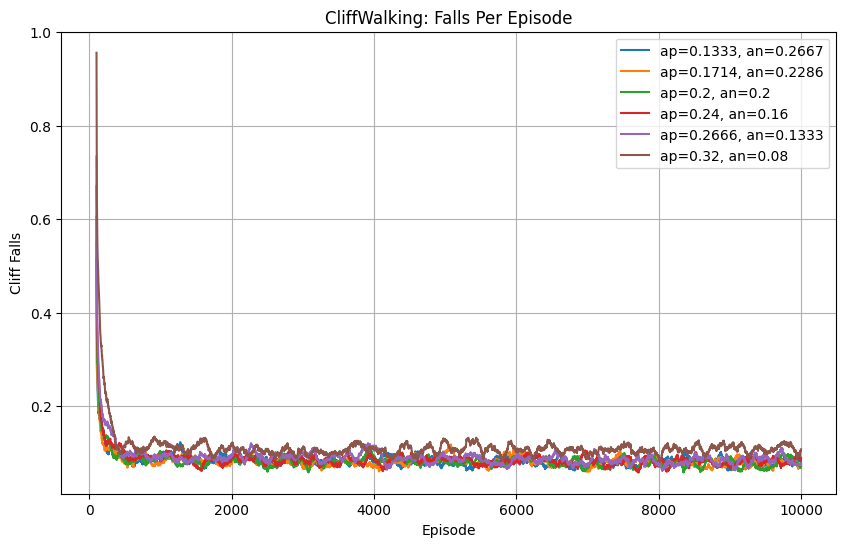

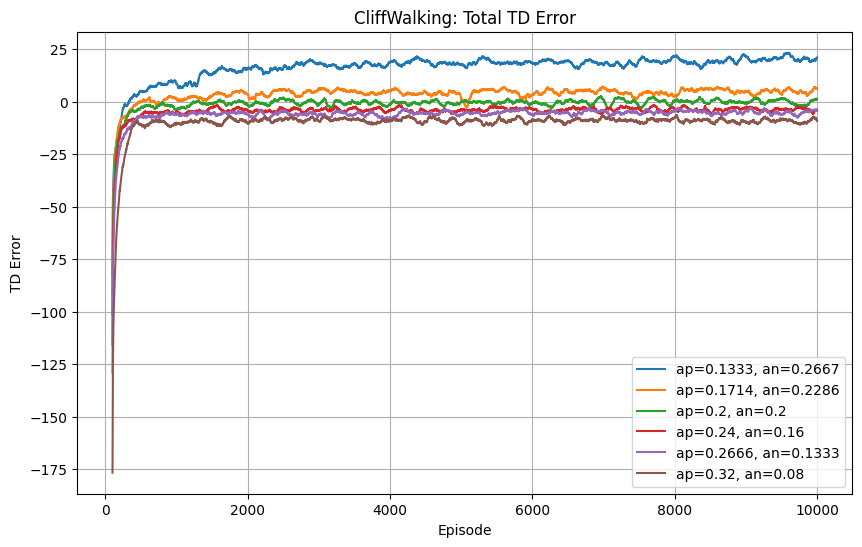

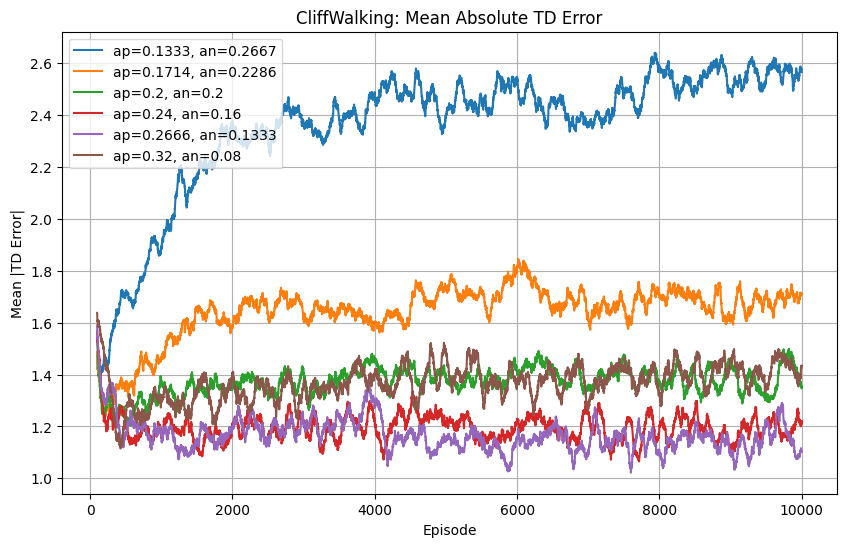

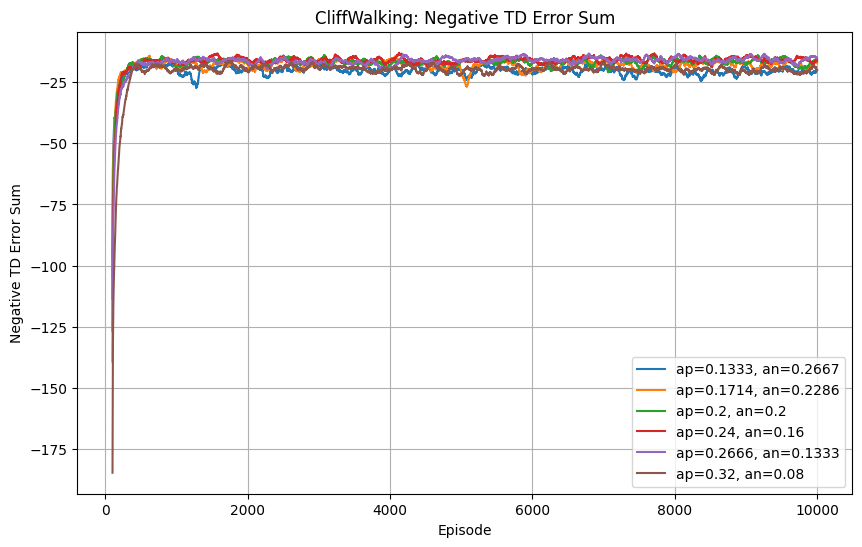

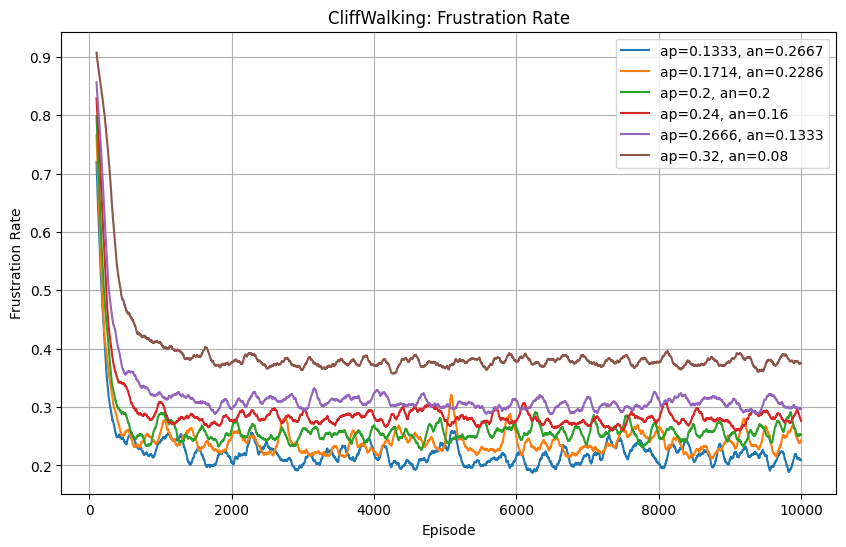

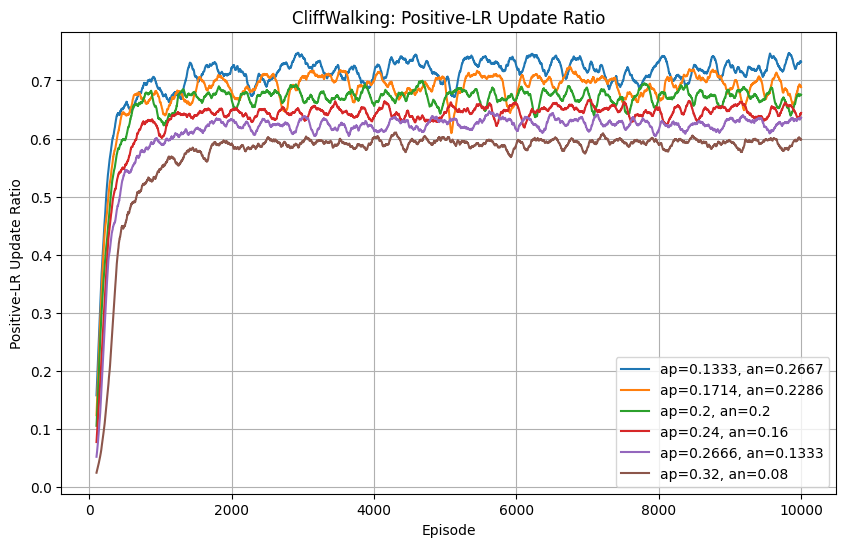

In [8]:
# all 15 sweeps
import experiments.sweep_plots_helper_thesis as thesis_cfg_mod

importlib.reload(thesis_cfg_mod)

cfg = thesis_cfg_mod.cliffwalking_training_thesis_config()

plot_sweep_training(
    pos_results,
    window_size=cfg["window_size"],
    label_fn=cfg["label_fn"],
    plot_specs=cfg["plot_specs"],
    start_episode=cfg["start_episode"],
    end_episode=cfg["end_episode"],
    use_td_error_v=cfg["use_td_error_v"],
)

In [9]:
# all 15 sweeps
import experiments.sweep_plots_helper_thesis as thesis_cfg_mod

importlib.reload(thesis_cfg_mod)

cfg = thesis_cfg_mod.cliffwalking_evaluation_thesis_config()

plot_sweep_evaluation(
    pos_results,
    window_size=cfg["window_size"],
    label_fn=cfg["label_fn"],
    plot_specs=cfg["plot_specs"],
    start_episode=cfg["start_episode"],
    end_episode=cfg["end_episode"],
)

ValueError: no values available after slicing for any series

## Frozen Lake

In [ ]:
# FrozenLake - confirmation bias
file_frozenlake_conf = Path("outputs/sweeps/frozenlake_final_results/frozenlake_conf_all_pairs.pkl")
with file_frozenlake_conf.open("rb") as f:
    conf_results = pickle.load(f)
print(f"Loaded {len(conf_results)} runs from {file_frozenlake_conf}")

In [ ]:
plot_sweep_training(
    cliffwalking_evaluation_plot_specs,
    window_size=500,
    start_episode=0,
)

In [ ]:
# FrozenLake - positivity bias
file_frozenlake_pos = Path("outputs/sweeps/frozenlake_final_results/frozenlake_pos_all_ratios.pkl")
with file_frozenlake_pos.open("rb") as f:
    pos_results = pickle.load(f)
print(f"Loaded {len(pos_results)} runs from {file_frozenlake_pos}")